<a href="https://colab.research.google.com/github/Tanvi030/FUTURE_DS_03/blob/main/altertask3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('/content/student_feedback.csv')
possible_text_cols = [col for col in df.columns if any(x in col.lower() for x in ['comment','remark','suggestion'])]
possible_text_cols

[]

In [ ]:
import pandas as pd
# Re-load the data
df = pd.read_csv('/content/student_feedback.csv')
# Look for potential columns for open feedback
possible_text_cols = [col for col in df.columns if any(x in col.lower() for x in ['comment','remark','suggestion','feedback','text'])]
possible_text_cols

[]

/tmp/ipython-input-4230338481.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_summary.index, y=rating_summary['mean'].values, palette='viridis')


'feedback_rating_summary.csv'

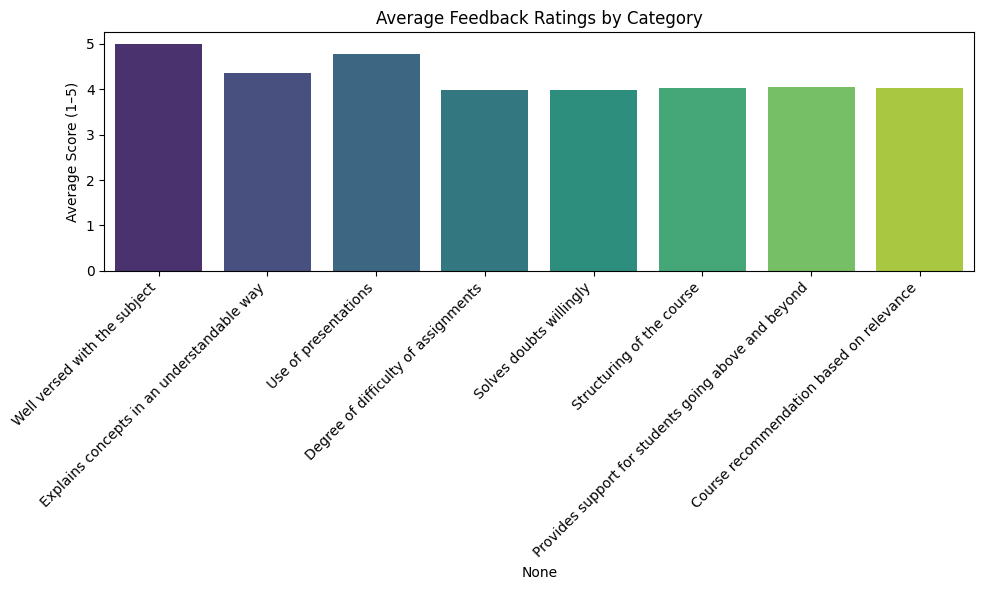

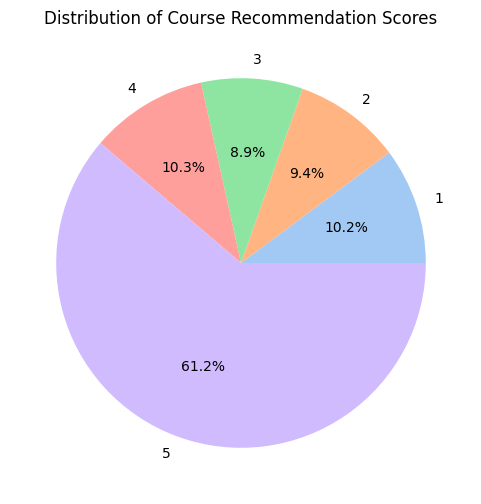

In [ ]:
# No comment columns found. We proceed with quantitative ratings analysis and visualization.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cleaned feedback data as per previously cleaned sample
cleaned_cols = [
    'Well versed with the subject',
    'Explains concepts in an understandable way',
    'Use of presentations',
    'Degree of difficulty of assignments',
    'Solves doubts willingly',
    'Structuring of the course',
    'Provides support for students going above and beyond',
    'Course recommendation based on relevance'
]

# Load full data again and clean it
feedback = pd.read_csv('student_feedback.csv')
feedback = feedback.drop(columns=[col for col in feedback.columns if 'Unnamed' in col or col == 'Student ID'])
for col in cleaned_cols:
    feedback[col] = feedback[col].clip(lower=1, upper=5)

# Overview statistics for each rating field
rating_summary = feedback.describe().T[['mean', 'std', 'min', 'max']]

# Bar chart for average scores
plt.figure(figsize=(10,6))
sns.barplot(x=rating_summary.index, y=rating_summary['mean'].values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Score (1–5)')
plt.title('Average Feedback Ratings by Category')
plt.tight_layout()
plt.savefig('bar_chart_scores.png')

# Pie chart for Course Recommendation
course_rec_counts = feedback['Course recommendation based on relevance'].value_counts().sort_index()
plt.figure(figsize=(6,6))
plt.pie(course_rec_counts, labels=course_rec_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Distribution of Course Recommendation Scores')
plt.savefig('pie_chart_recommendation.png')

# Save stat summary as CSV
table_path = 'feedback_rating_summary.csv'
rating_summary.to_csv(table_path)

table_path

In [ ]:
# We'll run a self-contained analysis pipeline on the uploaded CSV (`/mnt/data/student_feedback.csv`).
# The code will:
# 1. Load the CSV and show basic info
# 2. Detect rating and comment columns automatically (robust heuristics)
# 3. Clean/prepare data (normalize ratings, clean text)
# 4. Run sentiment analysis (try VADER/TextBlob, fallback to simple lexicon)
# 5. Produce and save visualizations (ratings distribution, sentiment pie, top words)
# 6. Save a cleaned CSV and a small summary report
#
# After code runs you'll get interactive DataFrame displays (if available) and links to saved files.
# NOTE: This environment may not have every NLP package installed or internet access; the code
# includes fallbacks so it still runs without additional installs.
# Execute now:

import os
import re
import math
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_dir = Path("/mnt/data/feedback_analysis_outputs")
output_dir.mkdir(parents=True, exist_ok=True)

csv_path = "/content/student_feedback.csv"
print("Loading:", csv_path)
try:
    df = pd.read_csv(csv_path, low_memory=False)
except Exception as e:
    # Try different encodings or engine
    print("First read_csv failed:", e)
    df = pd.read_csv(csv_path, encoding="latin-1", engine="python")

print("\nOriginal shape:", df.shape)
print("Columns:", list(df.columns[:20]))

# Standardize column names
df.columns = [str(c).strip().lower().replace("\n", " ").replace(" ", "_") for c in df.columns]

# Heuristic to detect rating column(s)
def find_rating_column(df):
    candidates = []
    for col in df.columns:
        ser = df[col]
        # try convert to numeric and examine range
        coerced = pd.to_numeric(ser, errors="coerce")
        non_null = coerced.dropna()
        if len(non_null) >= 5:
            mn, mx = non_null.min(), non_null.max()
            # ratings usually integers in 1-5, 0-10 or percentages 0-100
            if (1 <= mn <= 5 and 1 <= mx <= 5) or (0 <= mn <= 10 and 0 <= mx <= 10) or (0 <= mn <= 100 and 0 <= mx <= 100):
                candidates.append((col, len(non_null), mn, mx))
        # also check column name hints
        if any(k in col for k in ["rating", "score", "satisfaction", "rate"]):
            candidates.append((col, len(ser.dropna()), None, None))
    # pick best candidate by number of numeric values
    if not candidates:
        return None
    # prefer ones with numeric mn/mx info
    candidates_sorted = sorted(candidates, key=lambda x: x[1], reverse=True)
    return candidates_sorted[0][0]

rating_col = find_rating_column(df)
# Heuristic to find comments column
def find_comments_column(df):
    text_cols = [c for c in df.columns if df[c].dtype == object]
    # prefer columns with comment-like names
    for c in text_cols:
        if any(k in c for k in ["comment", "feedback", "suggest", "review", "experience", "remark"]):
            return c
    # else pick the longest-text column by average string length
    if text_cols:
        avg_len = {c: df[c].astype(str).map(len).mean() for c in text_cols}
        return max(avg_len, key=avg_len.get)
    return None

comments_col = find_comments_column(df)

print("\nDetected rating column:", rating_col)
print("Detected comments column:", comments_col)

# If rating_col not found, try to pick numeric column automatically
if rating_col is None:
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    rating_col = numeric_cols[0] if numeric_cols else None
    print("Fallback numeric rating_col:", rating_col)

# Make a copy and clean
df_clean = df.copy()

# Normalize rating to 1-5 scale when possible
if rating_col:
    df_clean["_raw_rating"] = df_clean[rating_col]
    # coerce to numeric
    df_clean["_rating_num"] = pd.to_numeric(df_clean[rating_col], errors="coerce")
    # If values appear to be 0-10 scale, rescale to 1-5
    mn = df_clean["_rating_num"].min(skipna=True)
    mx = df_clean["_rating_num"].max(skipna=True)
    if pd.notna(mn) and pd.notna(mx):
        if mx > 5 and mx <= 10 and mn >= 0:
            # rescale linear
            df_clean["_rating_1to5"] = ((df_clean["_rating_num"] - mn) / (mx - mn) * 4 + 1).round(2)
            reason = f"Rescaled numeric rating from {mn:.1f}-{mx:.1f} to 1-5"
        elif mx > 5 and mx <= 100 and mn >= 0:
            # percent scale 0-100 -> map to 1-5
            df_clean["_rating_1to5"] = ((df_clean["_rating_num"] / 100.0) * 4 + 1).round(2)
            reason = f"Rescaled percent-like rating (0-100) to 1-5"
        else:
            # assume already 1-5 or similar; clip to [1,5] and round
            df_clean["_rating_1to5"] = df_clean["_rating_num"].clip(lower=1, upper=5).round(2)
            reason = "Clipped numeric rating to [1,5]"
    else:
        df_clean["_rating_1to5"] = np.nan
        reason = "No numeric range detected; _rating_num contains NaNs"
else:
    df_clean["_raw_rating"] = np.nan
    df_clean["_rating_num"] = np.nan
    df_clean["_rating_1to5"] = np.nan
    reason = "No rating column detected"

print("\nRating normalization:", reason)
print("Rating counts (clean):\n", df_clean["_rating_1to5"].value_counts(dropna=False).sort_index())

# Clean comments
if comments_col:
    def clean_text(s):
        if pd.isna(s):
            return ""
        s = str(s)
        s = s.strip()
        # remove emails, urls, excessive spaces
        s = re.sub(r"\S+@\S+", " ", s)
        s = re.sub(r"http\S+|www\.\S+", " ", s)
        s = re.sub(r"[^A-Za-z0-9\s\.\,\'\-]", " ", s)
        s = re.sub(r"\s+", " ", s)
        return s.strip()
    df_clean["_comment_raw"] = df_clean[comments_col].astype(str)
    df_clean["_comment_clean"] = df_clean["_comment_raw"].map(clean_text)
else:
    df_clean["_comment_raw"] = ""
    df_clean["_comment_clean"] = ""

# Basic stats
ratings = df_clean["_rating_1to5"].dropna().astype(float)
n_total = len(df_clean)
n_with_rating = ratings.shape[0]
n_with_comment = (df_clean["_comment_clean"].str.len() > 0).sum()

summary = {
    "total_responses": n_total,
    "responses_with_rating": int(n_with_rating),
    "responses_with_comments": int(n_with_comment),
    "rating_mean": float(ratings.mean()) if n_with_rating>0 else None,
    "rating_median": float(ratings.median()) if n_with_rating>0 else None,
    "rating_std": float(ratings.std()) if n_with_rating>0 else None
}

print("\nSummary stats:", summary)

# Sentiment analysis: try VADER, then TextBlob, then fallback simple lexicon
sentiment_method = None
df_clean["_sentiment_compound"] = np.nan
df_clean["_sentiment_label"] = ""

# Try VADER first
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    def vader_score(s):
        if not s or s.strip()=="" or s.lower() in ["nan", "none"]:
            return None
        return analyzer.polarity_scores(s)["compound"]
    df_clean["_sentiment_compound"] = df_clean["_comment_clean"].map(lambda t: vader_score(t))
    sentiment_method = "vader"
except Exception as e:
    # Try TextBlob
    try:
        from textblob import TextBlob
        def tb_score(s):
            if not s or s.strip()=="" or s.lower() in ["nan", "none"]:
                return None
            return TextBlob(s).sentiment.polarity
        df_clean["_sentiment_compound"] = df_clean["_comment_clean"].map(lambda t: tb_score(t))
        sentiment_method = "textblob"
    except Exception as e2:
        # Fallback: small lexicon
        pos_words = set("""good great excellent amazing helpful fantastic loved love enjoyed awesome well clear interesting engaging perfect friendly satisfied satisfied""".split())
        neg_words = set("""bad poor terrible boring confusing boring awful horrible didn't didn'tlike dislike disappointed frustrated rude slow""".split())
        def lexicon_score(s):
            if not s or s.strip()=="" or s.lower() in ["nan", "none"]:
                return None
            words = re.findall(r"\b[a-zA-Z']{2,}\b", s.lower())
            p = sum(1 for w in words if w in pos_words)
            n = sum(1 for w in words if w in neg_words)
            if p==0 and n==0:
                return 0.0
            return float(p - n) / max(1, (p + n))
        df_clean["_sentiment_compound"] = df_clean["_comment_clean"].map(lambda t: lexicon_score(t))
        sentiment_method = "lexicon_fallback"

print("\nSentiment method used:", sentiment_method)

# Map compound to label
def compound_to_label(x):
    if pd.isna(x):
        return "no_comment"
    try:
        x = float(x)
    except:
        return "no_comment"
    if x >= 0.05:
        return "positive"
    elif x <= -0.05:
        return "negative"
    else:
        return "neutral"

df_clean["_sentiment_label"] = df_clean["_sentiment_compound"].map(compound_to_label)

# Save cleaned CSV
clean_csv_path = output_dir / "feedback_cleaned.csv"
df_clean.to_csv(clean_csv_path, index=False)

# Visualizations: 1) Ratings distribution (bar chart)
plt.figure(figsize=(8,5))
if n_with_rating>0:
    counts = ratings.value_counts().sort_index()
    # plot bar chart
    plt.bar(counts.index.astype(str), counts.values)
    plt.title("Ratings distribution (1-5)")
    plt.xlabel("Rating (1-5)")
    plt.ylabel("Count")
    ratings_plot_path = output_dir / "ratings_distribution.png"
    plt.savefig(ratings_plot_path, bbox_inches="tight")
    plt.close()
else:
    ratings_plot_path = None

# 2) Sentiment pie chart (positive/neutral/negative/no_comment)
plt.figure(figsize=(6,6))
sent_counts = df_clean["_sentiment_label"].value_counts()
labels = sent_counts.index.tolist()
sizes = sent_counts.values.tolist()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Sentiment distribution (from comments)")
sentiment_plot_path = output_dir / "sentiment_pie.png"
plt.savefig(sentiment_plot_path, bbox_inches="tight")
plt.close()

# 3) Top words bar chart (fall back if wordcloud not available)
all_comments = " ".join(df_clean["_comment_clean"].dropna().astype(str).tolist())
# simple stopwords (small set to keep offline)
stopwords = set("""a about above after again against all am an and any are aren't as at be because been before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on once only or other ought our ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves""".split())
words = re.findall(r"\b[a-zA-Z']{2,}\b", all_comments.lower())
words_filtered = [w for w in words if w not in stopwords and len(w)>2]
word_counts = Counter(words_filtered)
top_words = word_counts.most_common(25)

# If wordcloud is available, try to create it; otherwise create bar chart
wordcloud_path = output_dir / "top_words.png"
try:
    from wordcloud import WordCloud
    if all_comments.strip():
        wc = WordCloud(width=800, height=400, background_color=None, collocations=False).generate(" ".join(words_filtered))
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud (top words in comments)")
        plt.savefig(wordcloud_path, bbox_inches="tight")
        plt.close()
    else:
        raise Exception("No comments to make wordcloud")
except Exception as e:
    # fallback bar chart
    if len(top_words)>0:
        words_b, counts_b = zip(*top_words)
        plt.figure(figsize=(10,6))
        plt.barh(list(reversed(words_b)), list(reversed(counts_b)))
        plt.title("Top words in comments")
        plt.xlabel("Count")
        plt.tight_layout()
        plt.savefig(wordcloud_path, bbox_inches="tight")
        plt.close()
    else:
        wordcloud_path = None

# 4) Average sentiment by rating (if both available)
avg_sent_by_rating_path = output_dir / "avg_sentiment_by_rating.png"
if n_with_rating>0 and df_clean["_sentiment_compound"].notna().sum()>0:
    df_for_group = df_clean.dropna(subset=["_rating_1to5", "_sentiment_compound"])
    if not df_for_group.empty:
        grouped = df_for_group.groupby(df_for_group["_rating_1to5"].round(0))["_sentiment_compound"].mean().sort_index()
        plt.figure(figsize=(8,5))
        plt.plot(grouped.index.astype(int), grouped.values, marker='o')
        plt.title("Average sentiment (compound) by rounded rating")
        plt.xlabel("Rating (rounded)")
        plt.ylabel("Average sentiment compound score")
        plt.grid(True)
        plt.savefig(avg_sent_by_rating_path, bbox_inches="tight")
        plt.close()
    else:
        avg_sent_by_rating_path = None
else:
    avg_sent_by_rating_path = None

# Create a small textual summary
mean_rating = summary["rating_mean"]
pos_pct = (sent_counts.get("positive",0)/n_total)*100 if n_total>0 else 0
neg_pct = (sent_counts.get("negative",0)/n_total)*100 if n_total>0 else 0
neu_pct = (sent_counts.get("neutral",0)/n_total)*100 if n_total>0 else 0
no_comment_pct = (sent_counts.get("no_comment",0)/n_total)*100 if n_total>0 else 0

summary_lines = [
    f"Total responses: {n_total}",
    f"Responses with rating: {n_with_rating}",
    f"Responses with comments: {n_with_comment}",
    f"Average rating (1-5): {mean_rating:.2f}" if mean_rating is not None else "Average rating: N/A",
    f"Sentiment (comments): positive={pos_pct:.1f}%, neutral={neu_pct:.1f}%, negative={neg_pct:.1f}%, no_comment={no_comment_pct:.1f}%",
    f"Sentiment method used: {sentiment_method}"
]

# Basic suggestions derived from stats (automated)
suggestions = []
if mean_rating is None:
    suggestions.append("No numeric ratings found — consider adding a 1-5 rating question to your form.")
else:
    if mean_rating < 3.5:
        suggestions.append("Average rating is below 3.5 — review event format, content, and speaker quality. Consider collecting more detailed sub-ratings (content, pacing, materials).")
    elif mean_rating < 4.2:
        suggestions.append("Average rating is decent (3.5-4.2) — identify weaker sessions/topics and improve them; consider follow-up training for presenters.")
    else:
        suggestions.append("Average rating is strong — continue current practices and collect targeted feedback to identify small improvements.")

if neg_pct > 10:
    suggestions.append("More than 10% of comments are negative — analyse negative comments for recurring themes (e.g., 'pace', 'length', 'clarity'). Prioritise top 3 issues and address them for the next event.")

if n_with_comment < max(50, int(0.2*n_total)):
    suggestions.append("Low comment response rate — encourage qualitative feedback by asking one targeted open question and making responses optional but brief.")

report_text = "\n".join(summary_lines) + "\n\nSuggestions:\n" + "\n".join("- " + s for s in suggestions)

report_txt_path = output_dir / "feedback_summary.txt"
with open(report_txt_path, "w", encoding="utf-8") as f:
    f.write(report_text)

# Prepare simple dataframes to show to user
df_head = df_clean.head(50)[["_raw_rating","_rating_num","_rating_1to5","_comment_raw","_comment_clean","_sentiment_compound","_sentiment_label"]]
sent_counts_df = pd.DataFrame(sent_counts).reset_index().rename(columns={"index":"sentiment","_sentiment_label":"count"})
sent_counts_df.columns = ["sentiment","count"]

# Try to display DataFrames if helper available; else fallback to printing head and tables
try:
    import caas_jupyter_tools as cjt
    cjt.display_dataframe_to_user("Cleaned feedback preview (first 50 rows)", df_head)
    cjt.display_dataframe_to_user("Sentiment counts", sent_counts_df)
except Exception as e:
    print("\n--- Cleaned feedback preview (first 10 rows) ---")
    print(df_head.head(10).to_string(index=False))
    print("\n--- Sentiment counts ---")
    print(sent_counts_df.to_string(index=False))

# Print brief summary to notebook output
print("\n--- Short Summary ---")
print(report_text)

# List saved files for user
saved_files = {
    "cleaned_csv": str(clean_csv_path),
    "summary_text": str(report_txt_path),
    "ratings_plot": str(ratings_plot_path) if ratings_plot_path else None,
    "sentiment_plot": str(sentiment_plot_path) if sentiment_plot_path else None,
    "top_words_plot": str(wordcloud_path) if wordcloud_path else None,
    "avg_sent_by_rating": str(avg_sent_by_rating_path) if avg_sent_by_rating_path else None
}

print("\nSaved files:")
for k,v in saved_files.items():
    if v:
        print(f" - {k}: {v}")
    else:
        print(f" - {k}: None")

# Show first few rows as final friendly output
df_head_display = df_head.head(10)

# Save an aggregated CSV report for quick consumption (counts by rating and sentiment)
try:
    rating_counts_df = ratings.value_counts().sort_index().rename_axis("rating").reset_index(name="count") if n_with_rating>0 else pd.DataFrame()
    sentiment_counts_df = sent_counts_df.copy()
    agg_path = output_dir / "aggregated_counts.xlsx"
    with pd.ExcelWriter(agg_path) as writer:
        if not rating_counts_df.empty:
            rating_counts_df.to_excel(writer, sheet_name="rating_counts", index=False)
        sentiment_counts_df.to_excel(writer, sheet_name="sentiment_counts", index=False)
    print("\nWrote aggregated Excel to:", agg_path)
    saved_files["aggregated_excel"] = str(agg_path)
except Exception as e:
    print("Could not write aggregated excel:", e)

# Return values for user to inspect
saved_files, str(clean_csv_path), str(report_txt_path)


Loading: /content/student_feedback.csv

Original shape: (1001, 10)
Columns: ['Unnamed: 0', 'Student ID', 'Well versed with the subject', 'Explains concepts in an understandable way', 'Use of presentations', 'Degree of difficulty of assignments', 'Solves doubts willingly', 'Structuring of the course', 'Provides support for students going above and beyond', 'Course recommendation based on relevance']

Detected rating column: well_versed_with_the_subject
Detected comments column: None

Rating normalization: Rescaled numeric rating from 5.0-10.0 to 1-5
Rating counts (clean):
 _rating_1to5
1.0    165
1.8    172
2.6    152
3.4    177
4.2    182
5.0    153
Name: count, dtype: int64

Summary stats: {'total_responses': 1001, 'responses_with_rating': 1001, 'responses_with_comments': 0, 'rating_mean': 2.998001998001998, 'rating_median': 3.4, 'rating_std': 1.354398761072972}

Sentiment method used: textblob

--- Cleaned feedback preview (first 10 rows) ---
 _raw_rating  _rating_num  _rating_1to5 _

({'cleaned_csv': '/mnt/data/feedback_analysis_outputs/feedback_cleaned.csv',
  'summary_text': '/mnt/data/feedback_analysis_outputs/feedback_summary.txt',
  'ratings_plot': '/mnt/data/feedback_analysis_outputs/ratings_distribution.png',
  'sentiment_plot': '/mnt/data/feedback_analysis_outputs/sentiment_pie.png',
  'top_words_plot': None,
  'avg_sent_by_rating': None,
  'aggregated_excel': '/mnt/data/feedback_analysis_outputs/aggregated_counts.xlsx'},
 '/mnt/data/feedback_analysis_outputs/feedback_cleaned.csv',
 '/mnt/data/feedback_analysis_outputs/feedback_summary.txt')

In [ ]:
!pip install vaderSentiment textblob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd

# Save full feedback data with sentiment labels
df.to_excel('/content/drive/My Drive/feedback_with_sentiment.xlsx', index=False)

# Save only negative comments for theme analysis
neg_df.to_excel('/content/drive/My Drive/negative_comments.xlsx', index=False)

# Save the theme table (if you create one as DataFrame)
theme_table.to_excel('/content/drive/My Drive/theme_table.xlsx', index=False)


OSError: Cannot save file into a non-existent directory: '/content/drive/My Drive'

In [ ]:
from google.colab import files

df.to_excel('feedback_with_sentiment.xlsx', index=False)
files.download('feedback_with_sentiment.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>